# Retinal pyramid and addition of saccades


To imitate a retinal transformation on a image, we can mimic a fovea in the center (high density of cones and a better definition) and on the edges a higher density of rods (lower definition). 
To achieve it we used two differents methods :

1. The Laplacian pyramid 

Then to recreate a complete image, we add the saccades : the eye is moving, and when we combine the images together we get a visual scene on which only the points of interest are sharp. This is the second part of this notebook, combined with the Laplacian pyramid method to work with color.

2. Adding saccades to reconstruct the full visual field

Finally, 

3. Log-Gabor filters


## 1. Using only the Laplacian pyramid

### 1.1. Initialization parameters & functions

Parameters :

In [1]:
mode= 'bilinear' #resizing : continuous transition, reduces edges,contrast
width = 32 #side of the cropped image used to build the pyramid
base_levels = 1.61803
base_levels = 2 #downsampling/upsampling factor

N_batch = 4 #number of images 
pattern = 'i05june05_static_street_boston_p1010808'

In [2]:
n_sublevel = 2 #filters dictionnary, number of sublevels
n_azimuth = 12 #retinal transform characteristics 
n_theta = 12
n_phase = 2

Libraries :

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

from SLIP import imread
from SLIP import Image as Image_SLIP
import time

from PIL import Image

In [4]:
import torch
torch.set_default_tensor_type('torch.DoubleTensor')

In [5]:
import imageio

### 1.2. Loading an image

In [6]:
img_orig = Image.open('../data/i05june05_static_street_boston_p1010808.jpeg')

im_color_npy = np.asarray(img_orig)
N_X, N_Y, _ = im_color_npy.shape #dimensions 

ds= 1

#im=Image_SLIP({'N_X': N_X, 'N_Y': N_Y, 'do_mask': False})

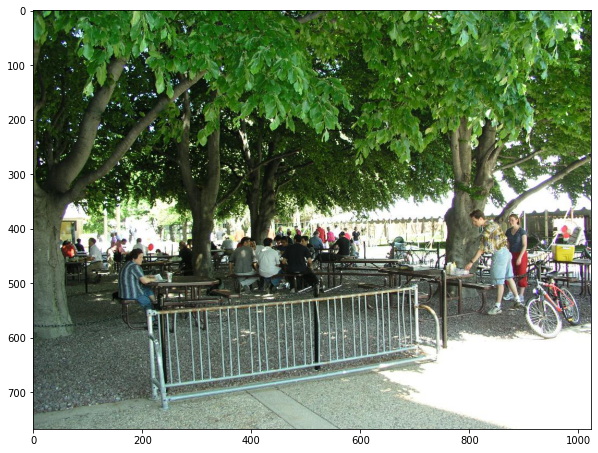

In [7]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im_color_npy/255)

### Functions :
To create the cropped pyramid

### Inversing the pyramid from the coefficients
Once the pyramid is done we can create the reconstructed image.

Using the roll function to create images centered on the successive focal points :

https://numpy.org/doc/stable/reference/generated/numpy.roll.html

Constructing the levels

Inversing the pyramid when adding saccades

### Log gabor functions :
Creating the filters

In [8]:
from LogGabor import LogGabor
pe = {'N_X': width, 'N_Y': width, 'do_mask': False, 'base_levels':
          base_levels, 'n_theta': 24, 'B_sf': 0.6, 'B_theta': np.pi/12 ,
      'use_cache': True, 'figpath': 'results', 'edgefigpath':
          'results/edges', 'matpath': 'cache_dir', 'edgematpath':
          'cache_dir/edges', 'datapath': 'database/', 'ext': '.pdf', 'figsize':
          14.0, 'formats': ['pdf', 'png', 'jpg'], 'dpi': 450, 'verbose': 0}                 #log-Gabor parameters
lg = LogGabor(pe)
print('lg shape=', lg.pe.N_X, lg.pe.N_Y)

lg shape= 32 32


In [9]:
from PYramid import local_filter

lg shape= 32 32


In [10]:
K = local_filter(azimuth=0, theta=0, phase=0, radius=width/4) 
print('K shape=', K.shape)
print('K min max=', K.min(), K.max())

K shape= (32, 32)
K min max= -0.41029997089061887 1.0


Creating the set K :

### 1.3. Converting to a tensor format
In order to interpolate and build the pyramid we need to work with tensors : the image is converted using the module Pytorch.

In [11]:
img_tens = torch.Tensor(im_color_npy[None, ...]) 
img_tens = img_tens.permute(0,3,1,2)
print('Tensor shape=', img_tens.shape) #image's size stored in img_tens.shape[-2:] 

Tensor shape= torch.Size([1, 3, 768, 1024])


### 1.4. Using torch to build up a Laplacian pyramid


https://www.cs.tau.ac.il/~dcor/Graphics/Exercises/burt83laplacian.pdf


To build the pyramid we down-sample recursively, until the image's size is 32*32.

The scale factor is 1/2 : for each iteration the image size is reduced by half.
https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.interpolate

In [12]:
from torch.nn.functional import interpolate 

img_down = img_tens.clone() 
n_levels = 0
while max(img_down.shape[-2:]) > width : # until obtaining sides inferior to width (cf cropped image at each step) 
    n_levels += 1 
    print('Tensor shape=', img_down.shape, ', n_levels=', n_levels) #each iteration reduces the image's size by a factor defined by base_levels
    #print(np.log(img_down.shape[-2:])/np.log(base_levels)-np.log(width)/np.log(base_levels))
    img_down = interpolate(img_down, scale_factor=1/base_levels, mode=mode) # downsampling 1/base_levels (bilinear mode)
n_levels += 1
print('Top tensor shape=', img_down.shape, ', Final n_levels=', n_levels)

#### Applying on the central crop of $32\times32$:

Creating the pyramid by calling the function

In [13]:
from PYramid import cropped_pyramid

In [14]:
img_crop = cropped_pyramid(img_tens, color=True, do_mask=True, verbose=False)[0]

Displaying central crops from successive residual images

Tensor shape= torch.Size([1, 6, 3, 32, 32])


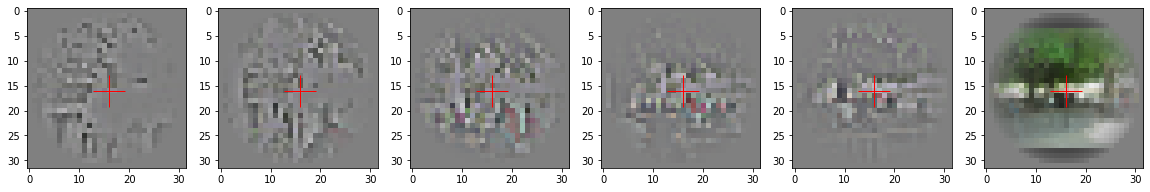

In [15]:
n_levels = int(np.log(np.max((N_X, N_Y))/width)/np.log(base_levels)) + 1
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
img_aff = img_crop.permute(0,1,3,4,2).numpy()
for i_level, ax in enumerate(axs):
    if i_level < n_levels-1:
        bias = 128
    else:
        bias = 0
    ax.imshow((img_aff[0, i_level, ...]+bias).astype('uint8'))
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape)  

### 1.5. Reconstruction
#### Inversing the pyramid using the function

In [16]:
from PYramid import inverse_pyramid

In [17]:
img_rec = inverse_pyramid(img_crop)

#### Plotting reconstructed image

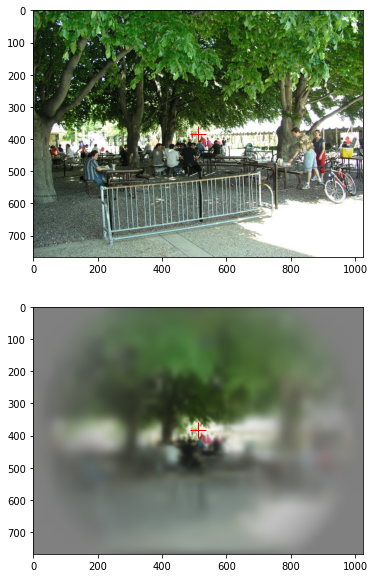

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    img = img.permute(0,2,3,1)[0,:,:,:]
    ax.imshow(img.numpy().astype('uint8'))
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

## 2. Adding the saccades
For this image we have an array containing the different points of interest covered by an eye using saccades.

In [19]:
name = 'i05june05_static_street_boston_p1010808'
impath = '../data/'+name+'.jpeg'
locpath = '../data/'+name+'.pkl'

### 2.1. Sliding gaze 
First we "roll" the image to place the point of interest in the center, as though the eye was moving. This way the image keeps the same dimension.

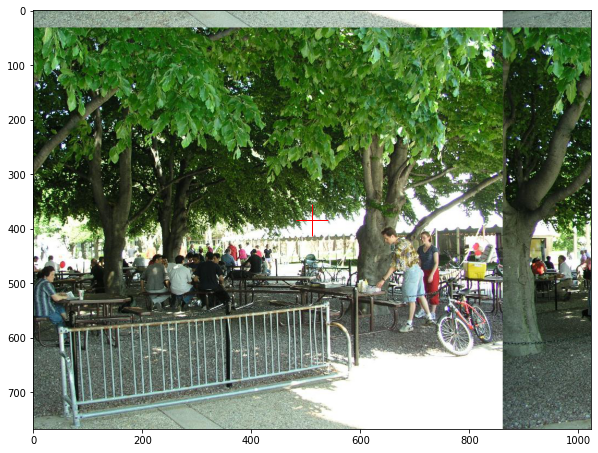

In [20]:
im_color_npy = np.roll(im_color_npy, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
im_color_npy = np.roll(im_color_npy, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom


fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im_color_npy/255)
ax.plot(N_Y//2, N_X//2, 'r+', ms=32);

In [21]:
import pickle
f = open(locpath,'rb')
loc_dict = pickle.load(f) # coordinates of the points of interest
loc_dict

{'image_name': 'i05june05_static_street_boston_p1010808',
 'barycenters': [(498, 384),
  (192, 425),
  (857, 437),
  (949, 513),
  (585, 546),
  (486, 288),
  (648, 415)]}

### 2.2. Saccade path

Converting to a tensor format

In [22]:
im_color_npy = np.asarray(img_orig)
img_tens = torch.Tensor(im_color_npy[None, ...]) 
img_tens = img_tens.permute(0,3,1,2)             #image's size stored in img_tens.shape[-2:]
print('Tensor shape=', img_tens.shape) 

Tensor shape= torch.Size([1, 3, 768, 1024])


In [23]:
loc_data_xy = np.array(loc_dict['barycenters'])
loc_data_ij = []
for coord in loc_data_xy:
    loc_data_ij += [[coord[1], coord[0]]]
loc_data_ij = np.array(loc_data_ij)
#print(loc_data_xy)
#print(loc_data_ij)

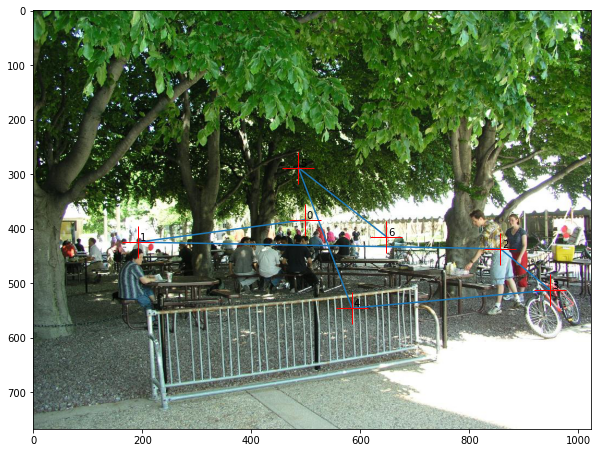

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im_color_npy, cmap='gray')

ax.plot(loc_data_xy[:,0], loc_data_xy[:,1])
for i, coord in enumerate(loc_data_xy):
    ax.plot(coord[0], coord[1], 'r+', ms=32)
    ax.text(coord[0]+3, coord[1]-3, i)

In [25]:
orig = np.zeros(2, dtype='int')
orig[0] = N_X//2
orig[1] = N_Y//2
print("Coordinates of the center : ", orig) 

Coordinates of the center :  [384 512]


In [26]:
from PYramid import saccade_to

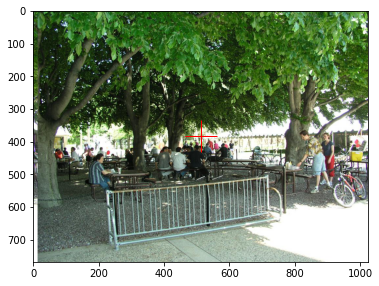

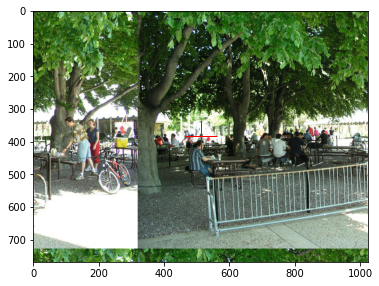

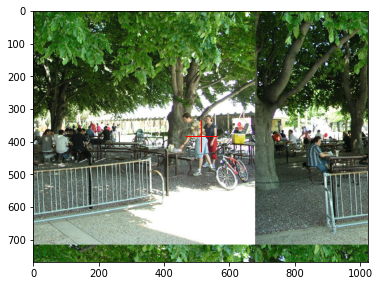

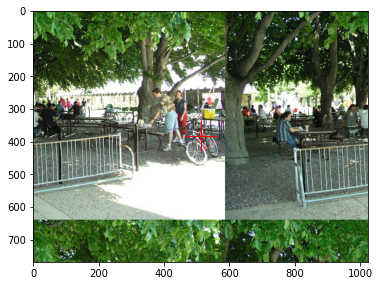

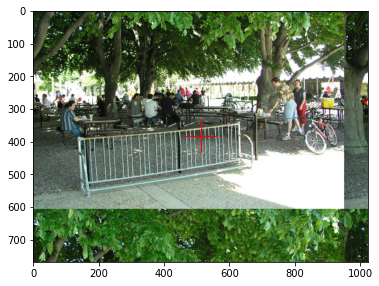

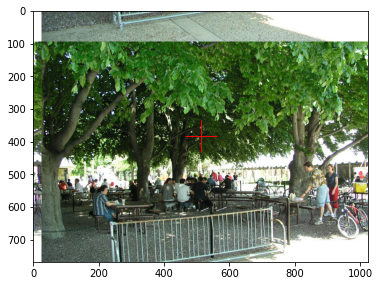

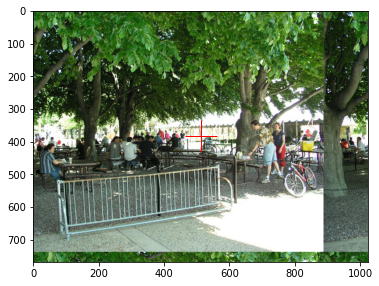

In [27]:
img_color_roll=[]
for i in range(len(loc_data_ij)):
    plt.figure(figsize=(6,6))
    #plt.imshow(img_color_roll[i])
    im_color_sac = saccade_to(im_color_npy, (N_X//2, N_Y//2), loc_data_ij[i])
    plt.imshow(im_color_sac)
    plt.plot(orig[1], orig[0], 'r+', ms=32)
    img_color_roll.append(im_color_sac)

In [28]:
#Computing number of iterations to downsample the image to a size < width
n_levels = int(np.log(np.max(im_color_npy.shape)/width)/np.log(base_levels)) + 1 
print('Computed n_levels=', n_levels)

Computed n_levels= 6


In [29]:
img_color_pyr_tens=[]
for i in range(len(loc_data_ij)):
    img_tens = torch.Tensor(img_color_roll[i][None, ...]) 
    img_tens = img_tens.permute(0,3,1,2)
    img_crop, level_size = cropped_pyramid(img_tens, do_mask=True,verbose=False)
    img_color_pyr_tens.append(img_crop)
print(level_size)

[[768, 1024], [384, 512], [192, 256], [96, 128], [48, 64], [24, 32]]


In [30]:
img_rec = inverse_pyramid(img_crop)

Plotting reconstructed image :

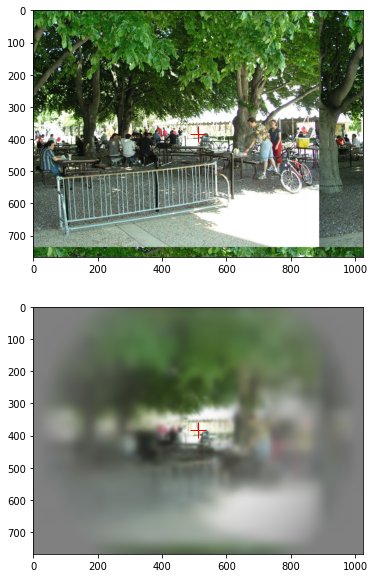

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
for ax, img in zip(axs, [img_tens, img_rec.detach()]):
    img = img.permute(0,2,3,1)[0,:,:,:]
    ax.imshow(img.numpy().astype('uint8'))
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

### 2.3 Reconstruction from multiple saccades

Creating all the images rolled according to saccade data, and using the Laplacian pyramid.

In [32]:
img_color_pyr_rec=[]
for i in range(len(loc_data_ij)):
    img_color_pyr_rec.append(inverse_pyramid(img_color_pyr_tens[i], verbose=True))
 

torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])
torch.Size([1, 3, 768, 1024])


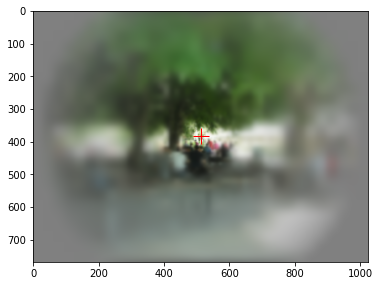

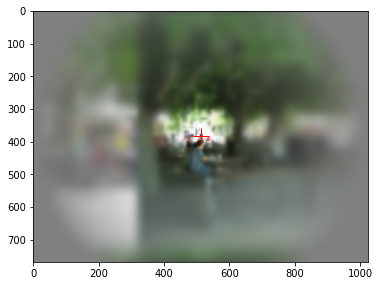

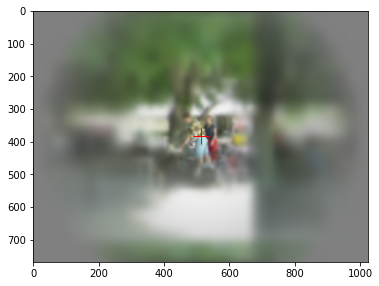

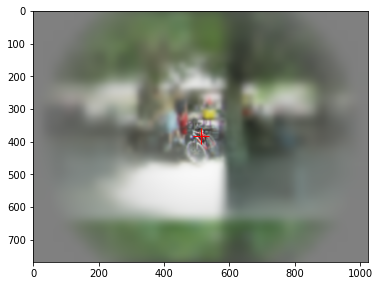

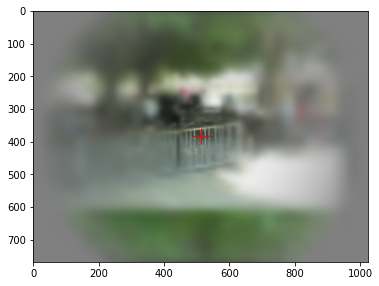

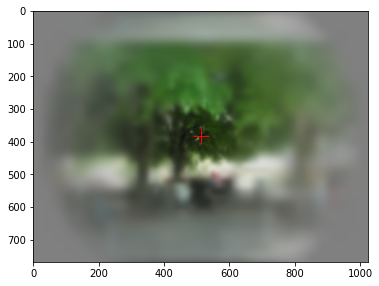

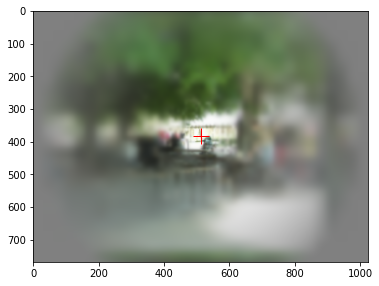

In [33]:
for i, img in enumerate(img_color_pyr_rec):
    plt.figure(figsize=(6,6))
    img_color_pyr_npy = img_color_pyr_rec[i].detach()  
    print(img_color_pyr_npy.shape)
    img_color_pyr_npy = img_color_pyr_npy.permute(0,2,3,1)[0,:,:,:]
    plt.imshow(img_color_pyr_npy.numpy().astype('uint8'))
    plt.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross

In [34]:
loc_data_ij[0] // 2**5

array([12, 15], dtype=int32)

The cropped images are layed on a blank image of the original image dimensions. 

On this array we can reconstruct the visual field, the eye travels the scene using saccades.

In [35]:
from PYramid import inverse_pyramid_saccades

In [36]:
print(img_crop.shape)

torch.Size([1, 6, 3, 32, 32])


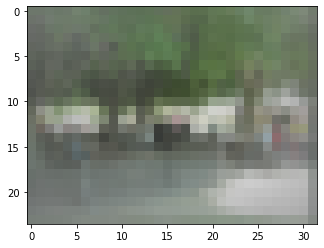

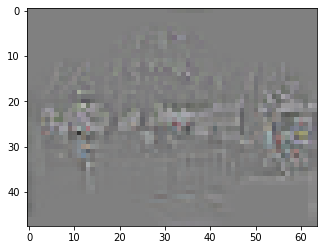

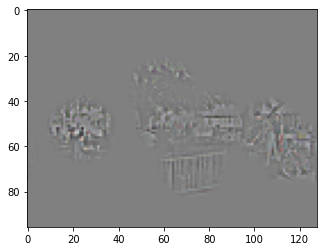

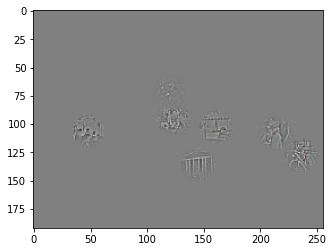

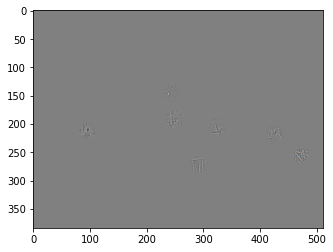

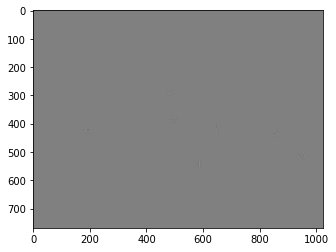

In [37]:
img_sac = inverse_pyramid_saccades(img_color_pyr_tens, img_crop, loc_data_ij, level_size, verbose=True)

## 3. Reconstructing the visual field
Using the multiple saccades and the pyramid only, the visual result is in color, and better than when using log-gabor filters. 
However, the 32*32 squares are visible (overlapped cropped images, not continuous), and further from the eye's biological functionning.

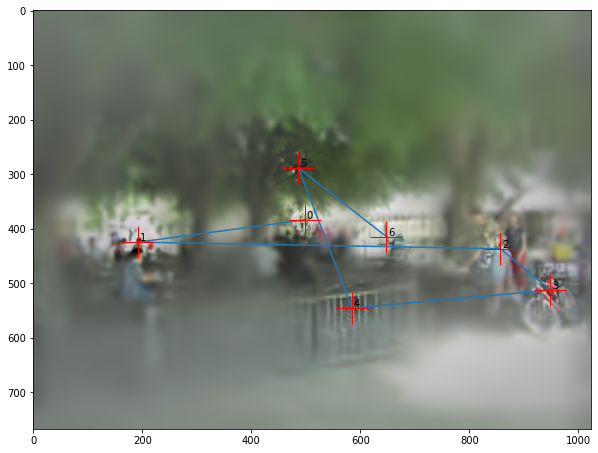

In [38]:
plt.figure(figsize=(10,10))
im = img_sac.detach().permute(0,2,3,1)[0,:,:,:].numpy()
im = np.clip(im,0,255).astype('uint8')

plt.imshow(im)
plt.plot(loc_data_ij[:,1], loc_data_ij[:,0])
for i, coord in enumerate(loc_dict['barycenters']):
    plt.plot(coord[0], coord[1], 'r+', ms=32)
    plt.text(coord[0]+3, coord[1]-3, i)

## 4. Log-Gabor filters
### 4.1. Loading an image

Le format du paramŠtre est incorrect - "data".


Tensor shape= torch.Size([1, 3, 768, 1024])


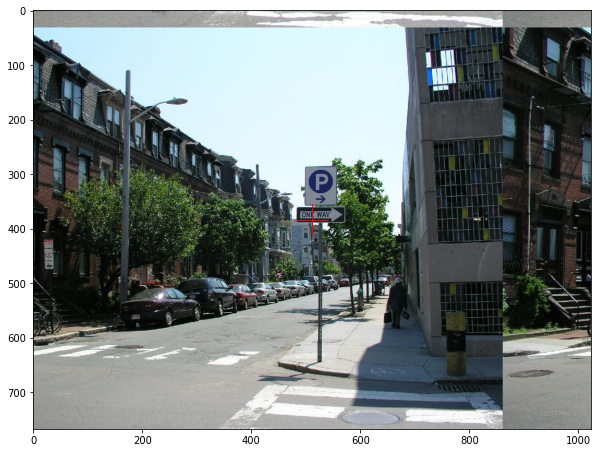

In [39]:
%ls ../data #list of images stored in file data
img_orig = Image.open('../data/i05june05_static_street_boston_p1010764.jpeg')
ds = 1
if ds>1: img_orig = img_orig[::ds, ::ds]
img_orig = np.roll(img_orig, -162//ds, axis=1) # sliding gaze to the right by moving image to the left
img_orig = np.roll(img_orig, 32//ds, axis=0) # sliding gaze to the top by moving image to the bottom

N_X, N_Y = img_orig.shape[0], img_orig.shape[1]
pe = {'N_X': N_X, 'N_Y': N_Y, 'do_mask': False} 

im = Image_SLIP(pe) 
img_orig_mean=img_orig.mean()
#img_orig = img_orig -img_orig.mean() #substracting the image's mean to each element
#img_orig *= im.mask[:,:,np.newaxis] #adding an oval mask  
img_tens = torch.Tensor(img_orig[None,...]).permute(0,3,1,2)
print('Tensor shape=', img_tens.shape) #converting to a tensor format, image's size stored in img_tens.shape[-2:]

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img_orig, cmap='gray')
ax.plot([img_orig.shape[1]/2], [img_orig.shape[0]/2], 'r+', ms=32);

### 4.2. Using torch to build up a Laplacian pyramid

In [40]:
from torch.nn.functional import interpolate 

Applying on the central crop of $32\times32$ and building the pyramid :

In [41]:
print(img_tens.shape)
img_crop = cropped_pyramid(img_tens, color=True, do_mask=True,verbose=True)[0]

torch.Size([1, 3, 768, 1024])
Tensor shape= torch.Size([1, 3, 384, 512]) , shape= torch.Size([1, 3, 768, 1024])
Tensor shape= torch.Size([1, 3, 192, 256]) , shape= torch.Size([1, 3, 384, 512])
Tensor shape= torch.Size([1, 3, 96, 128]) , shape= torch.Size([1, 3, 192, 256])
Tensor shape= torch.Size([1, 3, 48, 64]) , shape= torch.Size([1, 3, 96, 128])
Tensor shape= torch.Size([1, 3, 24, 32]) , shape= torch.Size([1, 3, 48, 64])
Top tensor shape= torch.Size([1, 3, 24, 32]) , Final n_levels= 6


### 4.3. Creating a set of filters

Log-Gabor filters:

documentation = https://nbviewer.jupyter.org/github/bicv/LogGabor/blob/master/LogGabor.ipynb
![Log-Gabor filters](https://camo.githubusercontent.com/867ab3c53cbeda20615518c722c60ec9071ee002/68747470733a2f2f6c617572656e7470657272696e65742e6769746875622e696f2f7075626c69636174696f6e2f666973636865722d30372d63762f66656174757265642e706e67)

In [42]:
from PYramid import get_K

In [43]:
K = get_K(verbose=True)

i_sublevel, sf_0, radius 0 0.3606737602222408 5.333333333333333
i_sublevel, sf_0, radius 1 0.2550348616491973 7.542472332656507
K shape= torch.Size([32, 32, 2, 12, 12, 2])
K min max= tensor(-1.) tensor(1.)


### 4.4. Applying the filters to the cropped images

In [44]:
from PYramid import log_gabor_transform

In [45]:
print('img_crop shape=', img_crop.shape) #cropped image tensor shape

log_gabor_coeffs = log_gabor_transform(img_crop, K) # applying K filters to the cropped image (convolution)

print('log_gabor_coeffs shape=', log_gabor_coeffs.shape)

img_crop shape= torch.Size([1, 6, 3, 32, 32])
log_gabor_coeffs shape= torch.Size([1, 6, 3, 2, 12, 12, 2])


Displaying central crops from successive residual images

Tensor shape= torch.Size([1, 6, 3, 32, 32])


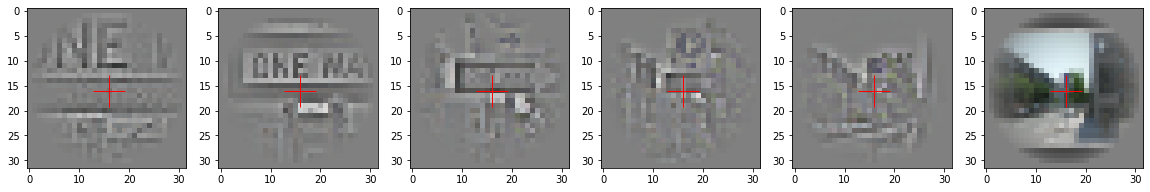

In [46]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
img_aff = img_crop.permute(0,1,3,4,2).numpy()
for i_level, ax in enumerate(axs):
    if i_level < n_levels-1:
        bias = 128
    else:
        bias = 0
    ax.imshow((img_aff[0, i_level, ...]+bias).astype('uint8'))
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_crop.shape) 

Inversing K filters

In [47]:
from PYramid import get_K_inv

Reconstruction layer by layer from cropped central images:

In [48]:
from PYramid import inverse_gabor

In [49]:
K_inv = get_K_inv(K)

img_rec=inverse_gabor(log_gabor_coeffs, K_inv)

Filter tensor shape= torch.Size([32, 32, 2, 12, 12, 2])
Reshaped filter tensor= torch.Size([1024, 576])
Tensor shape= torch.Size([576, 1024])
Tensor shape= torch.Size([2, 12, 12, 2, 32, 32])


Displaying central crops from successive residual images (cf pyramid)

Tensor shape= torch.Size([1, 6, 3, 32, 32])


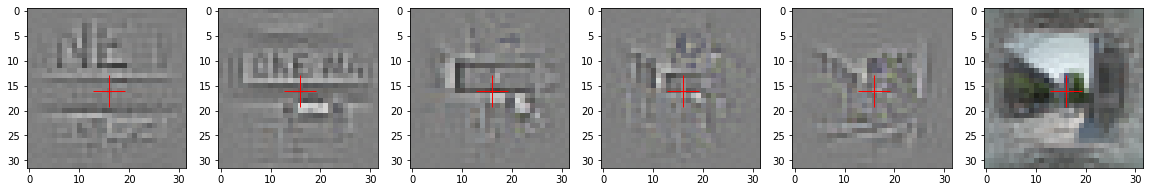

In [50]:
fig, axs = plt.subplots(1, n_levels, figsize=(20,20))
img_aff = img_rec.permute(0,1,3,4,2).numpy()
for i_level, ax in enumerate(axs):
    if i_level < n_levels-1:
        bias = 128
    else:
        bias = 0
    ax.imshow((img_aff[0, i_level, ...]+bias).astype('uint8'))
    ax.plot([width/2], [width/2], 'r+', ms=32);
print('Tensor shape=', img_rec.shape) 

### 4.5. Inverse pyramid from the coefficients

In [51]:
img_rec = inverse_pyramid(img_rec, color=True)

#### Plotting reconstructed image

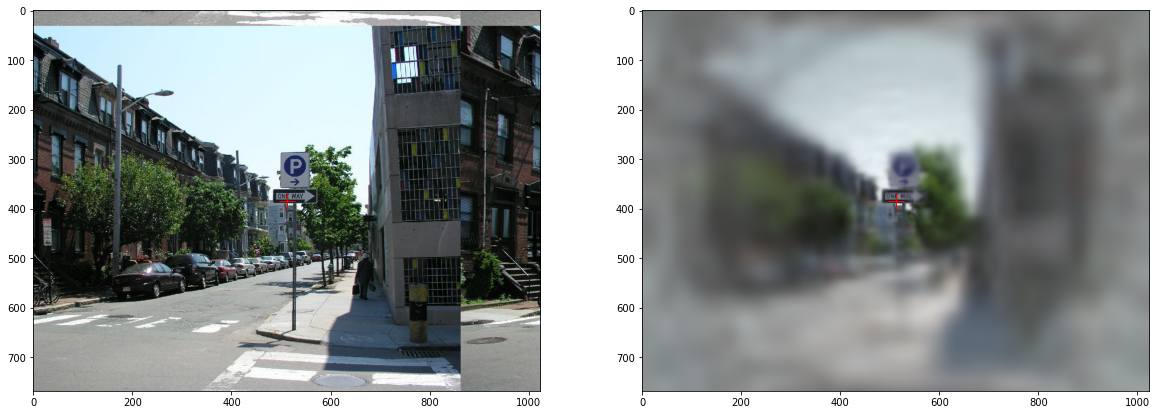

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(20,20))
for ax, img in zip(axs, [img_tens.permute(0,2,3,1), img_rec.detach().permute(0,2,3,1)]):
    ax.imshow(img[0, ...].numpy().astype('uint'))
    ax.plot([N_Y//2], [N_X//2], 'r+', ms=16); #central cross